# Q2: Cycle Generative Adversarial Network (CycleGAN)

In [13]:
# Load the necessary imports
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from library import datasets, models
from flax import linen as nn
from jax import random, numpy as jnp
import optax
import plotly.io as pio
from plotly.subplots import make_subplots
import plotly.graph_objects as go
pio.renderers.default = 'notebook_connected'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset

In the previous notebook, you saw how GAN tries to learn to generate samples from a desired distribution. In this notebook, you will use CycleGAN to learn how to map samples from one distribution to another. One of the key advantages of CycleGAN is that it does not require a paired dataset learn such mapping, since it is difficult to obtain paired datasets in practice. This means that each observation in one dataset does not need to be paired with an observation in the other dataset. In this homework, you will consider the mapping between two distributions of the blob dataset you saw in the GAN notebook. These are illustrated below.

In [14]:
key = random.PRNGKey(5)
key_A, key_B = random.split(key)

# Create dataset
A = datasets.utils.make_blobs(n_samples=1000, min_sigma=0, max_sigma=0.1, key=key_A)
B = datasets.utils.make_blobs(n_samples=1000, min_sigma=0, max_sigma=0.1, key=key_B)

real_A = A.get_tensors()
real_B = B.get_tensors()

In [15]:
fig = make_subplots(rows=1, cols=2, subplot_titles=["Distribution A", "Distribution B"])
fig.add_trace(go.Scatter(x=real_A[:, 0], y=real_A[:, 1], mode='markers', marker=dict(color="blue"),name='Real A'), row=1, col=1)
fig.add_trace(go.Scatter(x=real_B[:, 0], y=real_B[:, 1], mode='markers', marker=dict(color="green"), name='Real B'), row=1, col=2)
fig.update_layout(title_text="Real samples")
fig.show()

## Part (A): Initialize CycleGAN and interpret generated fake samples

Since you already learned how to create the discriminator and generator in the GAN notebook, you can reuse their architectures below. Remember that we have two different distributions now instead of one for GAN.

In [16]:
# Define ambient dimension, discriminator and generator
AMBIENT_DIM = 2

discriminator_A = nn.Sequential([ # TODO: Copy from GAN notebook
    nn.Dense(8),
    nn.relu,
    nn.Dense(16),
    nn.relu,
    nn.Dense(16),
    nn.relu,
    nn.Dense(8),
    nn.relu,
    nn.Dense(1),
])

discriminator_B = nn.Sequential([ # TODO: Copy from GAN notebook
    nn.Dense(8),
    nn.relu,
    nn.Dense(16),
    nn.relu,
    nn.Dense(16),
    nn.relu,
    nn.Dense(8),
    nn.relu,
    nn.Dense(1),
])

generator_AB = nn.Sequential([ # TODO: Copy from GAN notebook
    nn.Dense(8),
    nn.relu,
    nn.Dense(8),
    nn.relu,
    nn.Dense(4),
    nn.relu,
    nn.Dense(AMBIENT_DIM),
])

generator_BA = nn.Sequential([ # TODO: Copy from GAN notebook
    nn.Dense(8),
    nn.relu,
    nn.Dense(8),
    nn.relu,
    nn.Dense(4),
    nn.relu,
    nn.Dense(AMBIENT_DIM),
])


In [17]:
# Initialize model with generators, discriminators and loss function.
modules = {
        'generator_AB': generator_AB,
        'generator_BA': generator_BA,
        'discriminator_A': discriminator_A,
        'discriminator_B': discriminator_B,
    }

model = models.cyclegan.CycleGAN(modules, (AMBIENT_DIM,), (AMBIENT_DIM,))
model.initialize(optax.sigmoid_binary_cross_entropy)

In [18]:
# Get generators from untrained model and draw samples
gan_AB, gan_BA = model.create_distribution()
fake_A = gan_BA.draw_samples(real_B)
fake_B = gan_AB.draw_samples(real_A)

In [19]:
fig = make_subplots(rows=1, cols=2, subplot_titles = ["Distribution A", "Distribution B"])
fig.add_trace(go.Scatter(x=real_A[:, 0], y=real_A[:, 1], mode='markers', marker=dict(color="blue"),name='Real A'), row=1, col=1)
fig.add_trace(go.Scatter(x=real_B[:, 0], y=real_B[:, 1], mode='markers', marker=dict(color="green"),name='Real B'), row=1, col=2)
fig.add_trace(go.Scatter(x=fake_A[:, 0], y=fake_A[:, 1], mode='markers', marker=dict(color="red"),name='Fake'), row=1, col=1)
fig.add_trace(go.Scatter(x=fake_B[:, 0], y=fake_B[:, 1], mode='markers', marker=dict(color="red"),name='Fake', showlegend=False), row=1, col=2)
fig.update_layout(title_text="Real samples and fake samples from untrained generators")
fig.show()

**Q. Are the generated fake samples as you had expected? Why or why not?**

A.

## Part (B): Implement cycle consistency loss and train CycleGAN

For the CycleGAN model, we aim to solve the minimax game between the generators and the discriminators:
$$\underset{G_{AB}, G_{BA}}{min}\: \underset{D_A, D_B}{max}\: V(G_{AB}, G_{BA}, D_A, D_B) = \mathcal{L}(G_{AB},G_{BA},D_A, D_B)$$

The full objective is defined as:
$$\mathcal{L}(G_{AB},G_{BA},D_A, D_B) = \mathcal{L}(G_{AB},D_B,A,B) + \mathcal{L}(G_{BA},D_A,B,A) +\lambda \mathcal{L}_{cyc}(G_{AB}, G_{BA})$$
where $\lambda$ controls the relative importance of the two objectives (i.e. GAN or cycle consistency loss) and where the GAN and cycle consistency losses are defined as:
\begin{align*}
\mathcal{L}_{GAN}(G_{AB}, D_B, A, B) &= \mathbb{E}_{b \sim p_{data}(b)}\left[log \: D_B(b)\right]+\mathbb{E}_{a \sim p_{data}(a)}\left[log(1-D_B(G_{AB}(a)))\right] \\
\mathcal{L}_{cyc}(G_{AB}, G_{BA}) &= \mathbb{E}_{a \sim p_{data}(a)}\left[||G_{BA}(G_{AB}(a))-a||_1\right] + \mathbb{E}_{b \sim p_{data}(b)}\left[||G_{AB}(G_{BA}(b))-b||_1\right]
\end{align*}
Note that $\mathcal{L}(G_{BA},D_A,B,A)$ is calculated in similar fashion as $\mathcal{L}(G_{AB},D_B,A,B)$.


In this part, you should implement the GAN and cycle consistency loss functions from above in the train method in `cyclegan.py`. Once you have successfully implemented the functions, you can train the CycleGAN model below.

In [20]:
# Train CycleGAN
lambda_ = 5
history = model.train(A, B, optax.adam(learning_rate=5e-3), print_every=5, batch_size=1000, num_epochs=500, cycle_loss_weight=lambda_)

Epoch 0; Generator AB GAN loss:  0.6995; Generator BA GAN loss:  0.7239; Generator AB Cycle loss:  0.8255; Generator BA Cycle loss:  0.7572; Discriminator A loss:  0.6781; Discriminator B loss:  0.7197: : 1it [00:06,  6.08s/it]
Epoch 1; Generator AB GAN loss:  0.6938; Generator BA GAN loss:  0.7383; Generator AB Cycle loss:  0.8226; Generator BA Cycle loss:  0.7075; Discriminator A loss:  0.6693; Discriminator B loss:  0.7117: : 1it [00:00,  1.24it/s]
Epoch 2; Generator AB GAN loss:  0.6899; Generator BA GAN loss:  0.7550; Generator AB Cycle loss:  0.8195; Generator BA Cycle loss:  0.6524; Discriminator A loss:  0.6586; Discriminator B loss:  0.7079: : 1it [00:00,  1.23it/s]
Epoch 3; Generator AB GAN loss:  0.6879; Generator BA GAN loss:  0.7762; Generator AB Cycle loss:  0.8189; Generator BA Cycle loss:  0.5913; Discriminator A loss:  0.6465; Discriminator B loss:  0.7041: : 1it [00:00,  1.27it/s]
Epoch 4; Generator AB GAN loss:  0.6867; Generator BA GAN loss:  0.8022; Generator AB Cy

## Part (C): CycleGAN loss curves

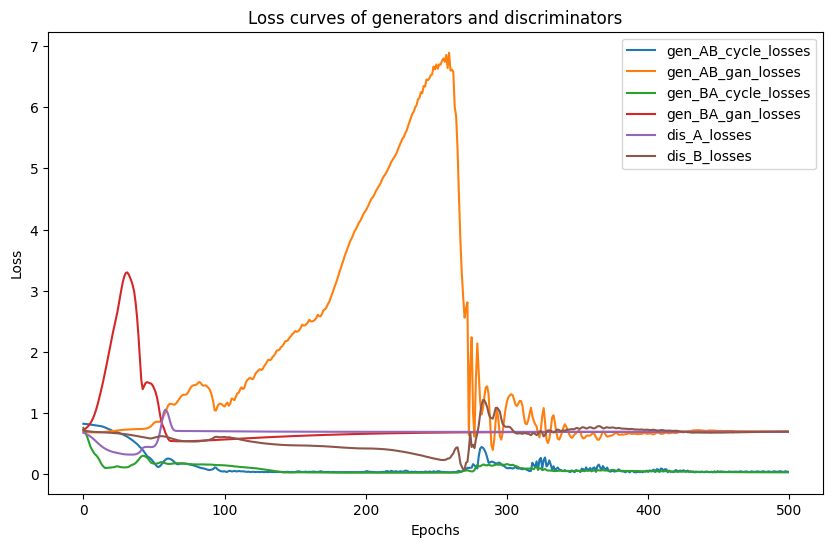

In [21]:
fig = plt.figure(figsize=(10, 6))
for key, value in history.items():
    plt.plot(range(len(value)), value, label=key)
plt.legend()
plt.title("Loss curves of generators and discriminators")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

**Q. Looking at the loss curves above, can you identify a limitation of CycleGAN?**

A. 

## Part (D): Visualize samples generated from trained generators

In [22]:
gan_AB, gan_BA = model.create_distribution()
fake_A = gan_BA.draw_samples(real_B)
fake_B = gan_AB.draw_samples(real_A)

In [23]:
fig = make_subplots(rows=1, cols=2, subplot_titles = ["Distribution A", "Distribution B"])
fig.add_trace(go.Scatter(x=real_A[:, 0], y=real_A[:, 1], mode='markers', marker=dict(color="blue"),name='Real A'), row=1, col=1)
fig.add_trace(go.Scatter(x=real_B[:, 0], y=real_B[:, 1], mode='markers', marker=dict(color="green"),name='Real B'), row=1, col=2)
fig.add_trace(go.Scatter(x=fake_A[:, 0], y=fake_A[:, 1], mode='markers', marker=dict(color="red"),name='Fake'), row=1, col=1)
fig.add_trace(go.Scatter(x=fake_B[:, 0], y=fake_B[:, 1], mode='markers', marker=dict(color="red"),name='Fake', showlegend=False), row=1, col=2)
fig.update_layout(title_text="Real samples and fake samples from trained generators")
fig.show()

**Q. How does the trained CycleGAN model differ from the trained GAN model in the previous notebook? Is it generating samples the way you expected?**

A. 

## Part (E-F): Pretraining and training with different lambda values

For the remaining part of this homework, you are going to explore the how the trained generators are affected when pretraining and training CycleGAN with different values $\lambda$ as described in the exercise. Feel free to use the code below for both Part (E) and (F).

### Pretrain

In [ ]:
# Reinitialize
model = models.cyclegan.CycleGAN(modules, (AMBIENT_DIM,), (AMBIENT_DIM,))
model.initialize(optax.sigmoid_binary_cross_entropy)

In [ ]:
# Pretrain
lambda_pretrain = 0 # TODO: Enter lambda for pretraining
history = model.train(A, B, optax.adam(learning_rate=5e-3), print_every=5, batch_size=1000, num_epochs=500, cycle_loss_weight=lambda_pretrain)

In [ ]:
# Obtain generators and samples
gan_AB, gan_BA = model.create_distribution()
fake_A = gan_BA.draw_samples(real_B)
fake_B = gan_AB.draw_samples(real_A)

# Visualize samples
fig = make_subplots(rows=1, cols=2, subplot_titles = ["Distribution A", "Distribution B"])
fig.add_trace(go.Scatter(x=real_A[:, 0], y=real_A[:, 1], mode='markers', marker=dict(color="blue"),name='Real A'), row=1, col=1)
fig.add_trace(go.Scatter(x=real_B[:, 0], y=real_B[:, 1], mode='markers', marker=dict(color="green"),name='Real B'), row=1, col=2)
fig.add_trace(go.Scatter(x=fake_A[:, 0], y=fake_A[:, 1], mode='markers', marker=dict(color="red"),name='Fake'), row=1, col=1)
fig.add_trace(go.Scatter(x=fake_B[:, 0], y=fake_B[:, 1], mode='markers', marker=dict(color="red"),name='Fake', showlegend=False), row=1, col=2)
fig.update_layout(title_text="Real samples and fake samples from pretrained generators")
fig.show()

### Further training

In [ ]:
# Fine tuning
lambda_train = 0 # TODO: Enter lambda value for fine tuning
history = model.train(A, B, optax.adam(learning_rate=5e-3), print_every=5, batch_size=1000, num_epochs=500, cycle_loss_weight=lambda_train)

In [ ]:
# Obtain generators and samples
gan_AB, gan_BA = model.create_distribution()
fake_A = gan_BA.draw_samples(real_B)
fake_B = gan_AB.draw_samples(real_A)

# Visualize samples
fig = make_subplots(rows=1, cols=2, subplot_titles = ["Distribution A", "Distribution B"])
fig.add_trace(go.Scatter(x=real_A[:, 0], y=real_A[:, 1], mode='markers', marker=dict(color="blue"),name='Real A'), row=1, col=1)
fig.add_trace(go.Scatter(x=real_B[:, 0], y=real_B[:, 1], mode='markers', marker=dict(color="green"),name='Real B'), row=1, col=2)
fig.add_trace(go.Scatter(x=fake_A[:, 0], y=fake_A[:, 1], mode='markers', marker=dict(color="red"),name='Fake'), row=1, col=1)
fig.add_trace(go.Scatter(x=fake_B[:, 0], y=fake_B[:, 1], mode='markers', marker=dict(color="red"),name='Fake', showlegend=False), row=1, col=2)
fig.update_layout(title_text="Real samples and fake samples from the trained generators")
fig.show()

**Q. What do you observe when pretraining with $\lambda=0$ and trained further with $\lambda>0$ and can you give a possible explanation?**

A.

**Q. What do you observe when pretraining with $\lambda>0$ and trained further with $\lambda=0$ and can you give a possible explanation?**

A.